# Market direction classifier
Note: 
* This model is fundamentally flawed due to the Efficients Markets Hypothesis (EMH) which states all available information is already priced into stock data. However, building and backtesting a model like this still provides valuable learning opportunities.
* This notebook is a work in progress 
* This notebook shouldn't be seen as actual trading advice to be applied in reality, more as a learning resource
* Transaction costs aren't taken into account in this model

In this work, I import historical candlestick data of EUR/USD exchange values from Twelve Data API. I then calculate returns over each time incriment by averaging Open-Close values. A set of 5 return values are then used to train a SVM classifier to predict the direction of market movements. The dataset is split into a train and test set to reduce overfitting. The test set is used to backtest performance of the model. Estimated returns (excluding transaction costs) are then calculated.

In [103]:
import requests
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from config import API_KEY

In [104]:
url = "https://twelve-data1.p.rapidapi.com/time_series"

querystring = {"symbol":"EUR/USD",
               "interval":"15min",
               "outputsize":"5000",
               "format":"json"}

headers = {
	"X-RapidAPI-Key": API_KEY,
	"X-RapidAPI-Host": "twelve-data1.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

# print(response.json())

In [105]:
df_in = pd.json_normalize(response.json()['values'], 
                        meta=['datetime', 'open', 'high', 'low', 'close', ])
df_in[['open', 'high', 'low', 'close', ]] = df_in[['open', 'high', 'low', 'close',]].apply(pd.to_numeric)
df = df_in.copy().iloc[::-1].reset_index(drop=True)
df.drop(index=0)
df

,datetime,open,high,low,close
0,2023-09-19 21:00:00,1.07005,1.07050,1.0699,1.0702
1,2023-09-19 21:15:00,1.07015,1.07050,1.0699,1.0705
2,2023-09-19 21:30:00,1.07045,1.07090,1.0704,1.0704
3,2023-09-19 21:45:00,1.07065,1.07100,1.0704,1.0708
4,2023-09-19 22:00:00,1.07090,1.07170,1.0707,1.0716
...,...,...,...,...,...
4995,2023-12-01 04:45:00,1.08980,1.08980,1.0888,1.0891
4996,2023-12-01 05:00:00,1.08890,1.08975,1.0889,1.0896
4997,2023-12-01 05:15:00,1.08980,1.09000,1.0897,1.0899
4998,2023-12-01 05:30:00,1.08985,1.08990,1.0892,1.0892


## Note this data doesn't include the bid-ask spread so we are essentially assuming 0 transaction cost
(An assumption of model - which is incorrect)

Text(0, 0.5, 'Avg EUR/USD')

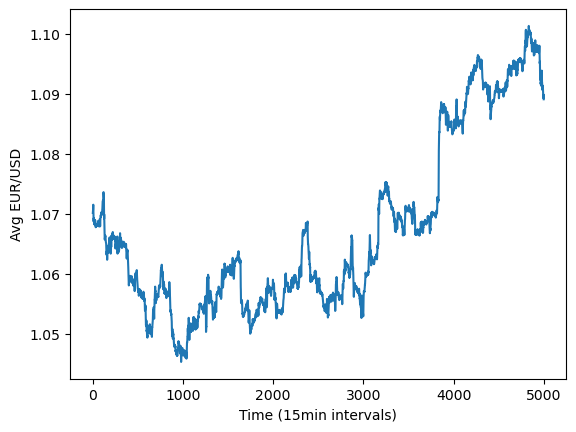

In [106]:
df['avg'] = df[['open','close']].mean(axis=1)
plt.plot(df['avg'])
plt.xlabel('Time (15min intervals)')
plt.ylabel('Avg EUR/USD')

In [107]:
df['returns'] = np.log(df['avg'] / df['avg'].shift(1)) 
df.dropna(inplace=True)
df['direction'] = np.sign(df['returns']).astype(int)

(array([3.000e+00, 5.000e+00, 1.700e+01, 2.120e+02, 3.351e+03, 1.322e+03,
        7.600e+01, 8.000e+00, 2.000e+00, 3.000e+00]),
 array([-0.00299465, -0.00236932, -0.00174398, -0.00111865, -0.00049331,
         0.00013202,  0.00075736,  0.00138269,  0.00200803,  0.00263336,
         0.0032587 ]),
 <BarContainer object of 10 artists>)

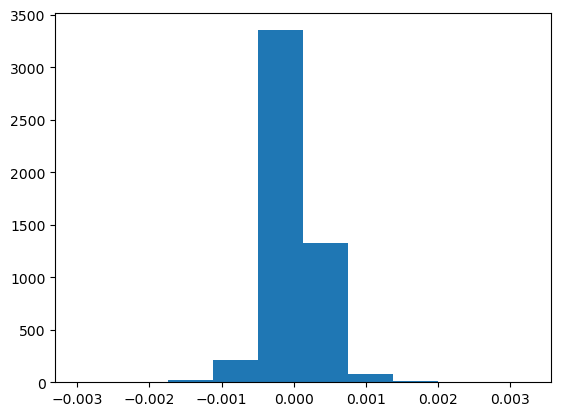

In [108]:
plt.hist(df['returns'])

In [109]:
def add_lagged_columns(df, column_to_lag, num_lags):
    """
    Add lagged columns to a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_to_lag (str): The column for which lagged columns are created.
        num_lags (int): The number of lagged columns to add.
    
    Returns:
        output_df: containing the direction and the lagged returns cols
    """
    cols = []
    for i in range(1, num_lags + 1):
        cols.append(f'{column_to_lag}_lag{i}')
        df[f'{column_to_lag}_lag{i}'] = df[column_to_lag].shift(i)
    return  cols

In [110]:
num_lags = 5
x_cols = add_lagged_columns(df,'returns', num_lags)
df.dropna(inplace=True)
df

,datetime,open,high,low,close,avg,returns,direction,returns_lag1,returns_lag2,returns_lag3,returns_lag4,returns_lag5
6,2023-09-19 22:30:00,1.07160,1.07180,1.0695,1.06970,1.070650,-0.000794,-1,0.000233,0.000490,0.000280,0.000093,0.000187
7,2023-09-19 22:45:00,1.06970,1.07010,1.0694,1.06995,1.069825,-0.000771,-1,-0.000794,0.000233,0.000490,0.000280,0.000093
8,2023-09-19 23:00:00,1.06990,1.07010,1.0685,1.06850,1.069200,-0.000584,-1,-0.000771,-0.000794,0.000233,0.000490,0.000280
9,2023-09-19 23:15:00,1.06840,1.06900,1.0683,1.06900,1.068700,-0.000468,-1,-0.000584,-0.000771,-0.000794,0.000233,0.000490
10,2023-09-19 23:30:00,1.06890,1.06970,1.0689,1.06940,1.069150,0.000421,1,-0.000468,-0.000584,-0.000771,-0.000794,0.000233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2023-12-01 04:45:00,1.08980,1.08980,1.0888,1.08910,1.089450,-0.000275,-1,-0.000138,-0.000505,-0.000229,-0.000138,-0.000412
4996,2023-12-01 05:00:00,1.08890,1.08975,1.0889,1.08960,1.089250,-0.000184,-1,-0.000275,-0.000138,-0.000505,-0.000229,-0.000138
4997,2023-12-01 05:15:00,1.08980,1.09000,1.0897,1.08990,1.089850,0.000551,1,-0.000184,-0.000275,-0.000138,-0.000505,-0.000229
4998,2023-12-01 05:30:00,1.08985,1.08990,1.0892,1.08920,1.089525,-0.000298,-1,0.000551,-0.000184,-0.000275,-0.000138,-0.000505


In [111]:
def fit_models(data):
    mfit = {model: models[model].fit(data[x_cols],data['direction'])
            for model in models.keys()}

def derive_positions(DF):
    for model in models.keys():
        DF['pos_' + model] = models[model].predict(DF[x_cols])

def evaluate_strats(data):
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')
    return sel


In [112]:
# train, test = train_test_split(df, test_size=0.5, shuffle=True, random_state=100)

split = int(len(df) * 0.5)
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()

train = train.copy().sort_index()
test = test.copy().sort_index()

In [113]:
models = {
 'svm': SVC(C=1)
 }

In [114]:
fit_models(train)
derive_positions(test)
sel = evaluate_strats(test)
test[sel].sum().apply(np.exp)

returns      1.030053
strat_svm    1.269164
dtype: float64

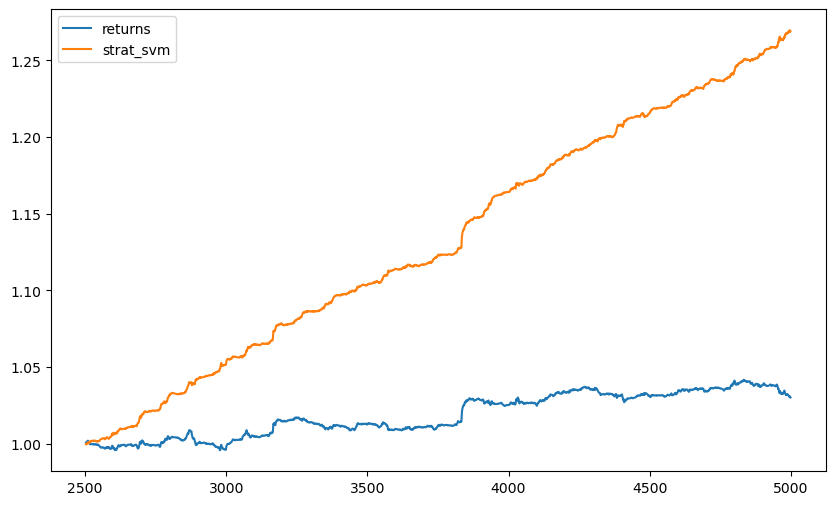

In [115]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));